# Task B

In [35]:
import numpy as np
from scipy.linalg import expm, sqrtm
from skimage import measure
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from matplotlib.path import Path
import cvxpy as cp
import pickle

In [36]:
# define the size of the Fock space
N = 20

In [37]:
def annihilation_operator(N):
  a = np.zeros((N, N), dtype=complex)
  for n in range(1, N):
    a[n-1, n] = np.sqrt(n)
  return a

In [38]:
def displacement_operator(alpha, N):
    a = annihilation_operator(N)
    a_dag = a.conj().T
    D_gen = alpha * a_dag - np.conj(alpha) * a
    return expm(D_gen)

In [39]:
def parity_operator(N):
    a = annihilation_operator(N)
    a_dag = a.conj().T
    number_operator = a_dag @ a
    return expm(1j * np.pi * number_operator)

In [40]:
def parity_operator_fock(N):
    return np.diag([(-1)**n for n in range(N)])

In [41]:
def wigner(alpha, rho, N):
    D = displacement_operator(alpha, N)
    P = parity_operator(N)
    D_dag = D.conj().T
    return (2 / np.pi) * np.real(np.trace(D @ P @ D_dag @ rho))

In [42]:
def get_measure_op(alpha, N):
  D = displacement_operator(alpha, N)
  P = parity_operator(N)
  D_dag = D.conj().T
  I = np.eye(N)
  return 0.5 * (I + D @ P @ D_dag)

In [43]:
def fidelity(rho_reconstructed, rho_true):
  root_rho_true = sqrtm(rho_true)
  inner = root_rho_true @ rho_reconstructed @ root_rho_true
  sqrt_inner = sqrtm(inner)
  fid = np.real(np.trace(sqrt_inner))
  return fid ** 2

In [44]:
def get_filtered_contours(Z, contour_level=0.4, min_length=20):
    contours = measure.find_contours(np.abs(Z), level=contour_level)
    print('-----------')
    print(len(contours))
    print('----------')
    def contour_length(contour):
        d = np.diff(contour, axis=0)
        return np.sum(np.sqrt(np.sum(d**2, axis=1)))
    filtered_contours = [cnt for cnt in contours if contour_length(cnt) > min_length]
    return filtered_contours

def convert_contour_to_physical(contour, X, Y):
    physical_x = np.interp(contour[:, 1], np.arange(len(X)), X)
    physical_y = np.interp(contour[:, 0], np.arange(len(Y)), Y)
    return np.column_stack((physical_x, physical_y))

def sample_contours_and_background(X, Y, Z, contour_level=0.4, min_length=2, total_points=250, inside_ratio=0.4):
    wigner_data = np.nan_to_num(Z.copy())

    print(wigner_data.shape)
    print(X.shape)
    print(Y.shape)

    # For rectangular grids, we need to handle different dimensions for rows and columns
    rows, cols = wigner_data.shape
    edge_row = rows - 1
    edge_col = cols - 1
    
    # Calculate average of the four edges (top, bottom, left, right)
    top_edge_avg = np.sum(wigner_data[0, :]) / cols
    bottom_edge_avg = np.sum(wigner_data[edge_row, :]) / cols
    left_edge_avg = np.sum(wigner_data[:, 0]) / rows
    right_edge_avg = np.sum(wigner_data[:, edge_col]) / rows
    
    # Take the average of all four edges
    b = (top_edge_avg + bottom_edge_avg + left_edge_avg + right_edge_avg) / 4
    wigner_data = wigner_data - b

    # Normalize the Wigner function
    # Get grid step sizes for proper integration
    dx = np.mean(np.diff(X))
    dy = np.mean(np.diff(Y))
    
    # For rectangular grids, directly compute the integral with proper scaling
    wigner_integral = np.sum(wigner_data) * dx * dy
    wigner_data = wigner_data/ wigner_integral
    sigma = 3
    wigner_data = gaussian_filter(wigner_data, sigma=sigma)

    filtered_contours = get_filtered_contours(wigner_data, contour_level, min_length)

    fig, ax = plt.subplots(figsize=(8, 6))
    extent = [X.min(), X.max(), Y.min(), Y.max()]
    im = ax.imshow(Z, extent=extent, origin='lower', aspect='auto')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Original Wigner Function with Contours')

    for contour in filtered_contours:
        try:
            # Convert contour coordinates to indices and ensure they are within bounds
            x_indices = contour[:, 1].astype(int)
            y_indices = contour[:, 0].astype(int)
            
            # Filter out invalid indices
            valid_mask = (x_indices >= 0) & (x_indices < len(X)) & (y_indices >= 0) & (y_indices < len(Y))
            
            if np.any(valid_mask):
                ax.plot(X[x_indices[valid_mask]], Y[y_indices[valid_mask]], color='white')
        except Exception as e:
            print(f"Error plotting contour: {e}")
    fig.colorbar(im, label='Wigner Function')
    plt.show()


    roi_polygons = [convert_contour_to_physical(contour, X, Y) for contour in filtered_contours]
    XX, YY = np.meshgrid(X, Y, indexing='ij')
    grid_points = np.column_stack((XX.ravel(), YY.ravel()))
    I, J = np.indices((len(X), len(Y)))
    grid_indices = np.column_stack((I.ravel(), J.ravel()))
    inside_mask = np.zeros(len(grid_points), dtype=bool)
    for polygon in roi_polygons:
        poly_path = Path(polygon)
        inside_mask |= poly_path.contains_points(grid_points)
    inside_points = grid_points[inside_mask]
    outside_points = grid_points[~inside_mask]
    inside_idx = grid_indices[inside_mask]
    outside_idx = grid_indices[~inside_mask]
    desired_inside = int(total_points * inside_ratio)
    desired_outside = total_points - desired_inside
    if len(inside_points) < desired_inside:
        sampled_inside_points = inside_points
        sampled_inside_idx = inside_idx
        extra_needed = total_points - len(inside_points)
        if len(outside_points) < extra_needed:
            sampled_outside_points = outside_points
            sampled_outside_idx = outside_idx
        else:
            samp_idx = np.random.choice(len(outside_points), size=extra_needed, replace=False)
            sampled_outside_points = outside_points[samp_idx]
            sampled_outside_idx = outside_idx[samp_idx]
    elif len(outside_points) < desired_outside:
        sampled_outside_points = outside_points
        sampled_outside_idx = outside_idx
        extra_needed = total_points - len(outside_points)
        if len(inside_points) < extra_needed:
            sampled_inside_points = inside_points
            sampled_inside_idx = inside_idx
        else:
            samp_idx = np.random.choice(len(inside_points), size=extra_needed, replace=False)
            sampled_inside_points = inside_points[samp_idx]
            sampled_inside_idx = inside_idx[samp_idx]
    else:
        samp_inside = np.random.choice(len(inside_points), size=desired_inside, replace=False)
        samp_outside = np.random.choice(len(outside_points), size=desired_outside, replace=False)
        sampled_inside_points = inside_points[samp_inside]
        sampled_inside_idx = inside_idx[samp_inside]
        sampled_outside_points = outside_points[samp_outside]
        sampled_outside_idx = outside_idx[samp_outside]
    sampled_points = np.concatenate([sampled_inside_points, sampled_outside_points], axis=0)
    sampled_indices = np.concatenate([sampled_inside_idx, sampled_outside_idx], axis=0)
    sampled_X = sampled_points[:, 0]
    sampled_Y = sampled_points[:, 1]
    sampled_Z = np.array([Z[i, j] for i, j in sampled_indices])
    return sampled_X, sampled_Y, sampled_Z

In [52]:
def sample_measurement_operators(X, Y, Z, N, num_samples=100):
    sampled_X, sampled_Y, sampled_Z = sample_contours_and_background(X, Y, Z)

    alpha_samples = []
    w_exp_measurements = []
    measurement_operators = []

    for x, y, w_val in zip(sampled_X, sampled_Y, sampled_Z):
        alpha = x + 1j*y
        # convert Wigner to expectation value via your calibration
        w_k = 0.5 * (1 + (np.pi/2) * w_val)

        alpha_samples.append(alpha)
        w_exp_measurements.append(w_k)
        measurement_operators.append(get_measure_op(alpha, N))

    return alpha_samples, w_exp_measurements, measurement_operators

In [ ]:
def reconstruct_density_matrix(w_exp_measurements, measurement_operators, N, solver='SCS'):
    rho = cp.Variable((N, N), complex=True)

    constraints = [
        rho == rho.H,                   # Hermitian constraint
        rho >> np.zeros((N, N)),         # Positive semidefinite constraint
        cp.trace(rho) == 1              # Trace equals 1
    ]

    # Build the objective function (least squares formulation)
    objective_terms = []
    for i in range(len(measurement_operators)):
        E_k_numpy = measurement_operators[i]  # measurement operator as a numpy array
        w_k = w_exp_measurements[i]             # experimental measurement value

        # The term is the squared difference of the predicted measurement value
        # (given by trace(E_k @ rho)) and the experimental outcome.
        term = cp.square(cp.abs(cp.trace(E_k_numpy @ rho) - w_k))
        objective_terms.append(term)

    # Formulate the overall optimization objective by summing the individual terms.
    objective = cp.Minimize(cp.sum(objective_terms))

    # Define and solve the optimization problem.
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=solver)

    return rho.value, prob

In [47]:
file_path = "../data/experimental/wigner_fock_zero.pickle"
with open(file_path, 'rb') as f:
    data = pickle.load(f)

In [48]:
def get_density_matrix(data, N):
    X, Y, Z = data
    alpha_sample, w_exp_measurements, measurement_operators = sample_measurement_operators(X, Y, Z, N)
    reconstructed_rho, prob = reconstruct_density_matrix(w_exp_measurements, measurement_operators, N, solver='SCS')
    return reconstructed_rho

(100, 100)
(100,)
(100,)
-----------
1
----------


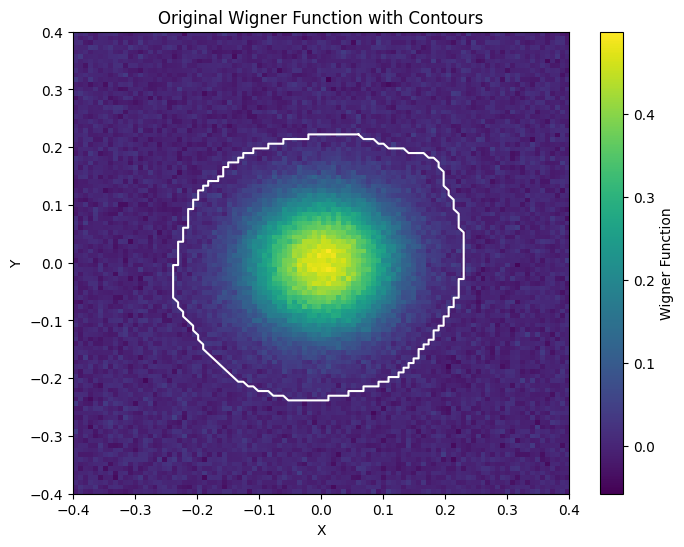

In [49]:
reconstructed_rho = get_density_matrix(data, N)

In [50]:
def plot_wigner_comparison(file_path, num_samples):
    with open(file_path, 'rb') as f:
        X, Y, Z = pickle.load(f)

    alpha_measurements, w_exp_measurements, measurement_operators = sample_measurement_operators(X, Y, Z, N, num_samples)

    reconstructed_rho, prob = reconstruct_density_matrix(w_exp_measurements, measurement_operators, N, solver='SCS')

    reconstructed_Z = np.zeros_like(Z, dtype=float)

    for i in range(len(X)):
        for j in range(len(Y)):
            alpha = X[i] + 1j * Y[j]
            reconstructed_Z[i, j] = wigner(alpha, reconstructed_rho, N)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    extent = [X.min(), X.max(), Y.min(), Y.max()]

    im0 = axs[0].imshow(Z, extent=extent, origin='lower', cmap='jet', aspect='auto')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')
    axs[0].set_title('Original Wigner Function')
    fig.colorbar(im0, ax=axs[0], label='Wigner Function')

    im1 = axs[1].imshow(reconstructed_Z, extent=extent, origin='lower', cmap='jet', aspect='auto')
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    axs[1].set_title('Reconstructed Wigner Function')
    fig.colorbar(im1, ax=axs[1], label='Wigner Function')

    plt.tight_layout()
    plt.show()

(100, 100)
(100,)
(100,)
-----------
1
----------


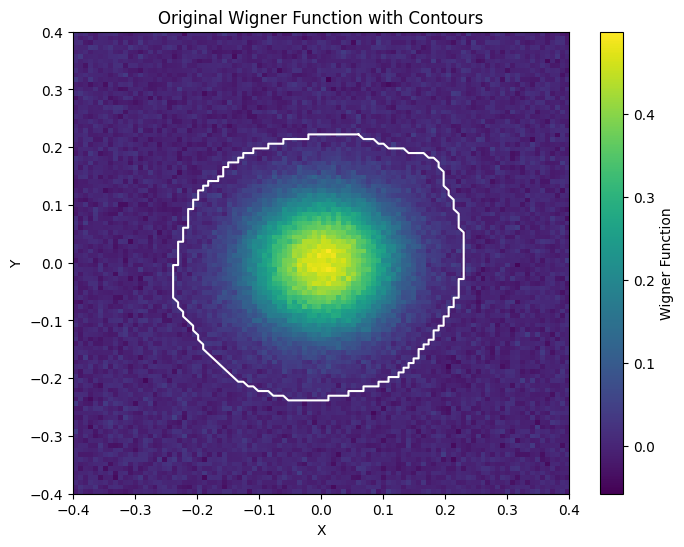

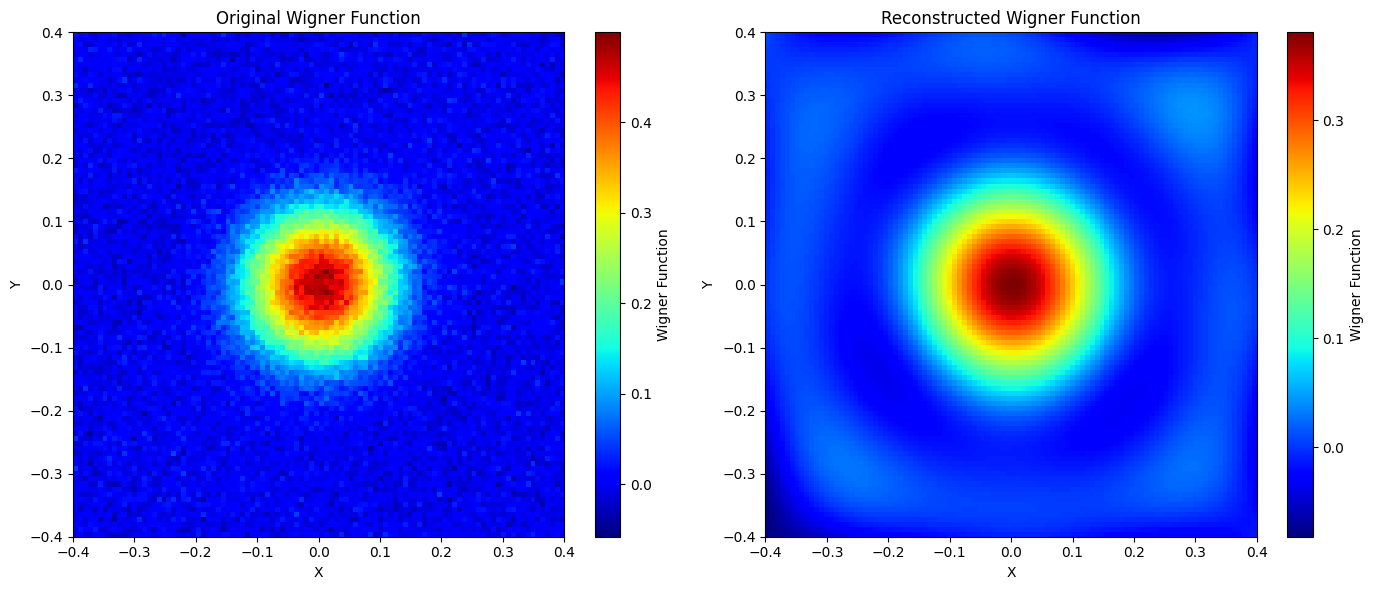

In [51]:
num_samples = 1000
plot_wigner_comparison(file_path, num_samples)